# RF Classification

Using [this](https://www.datacamp.com/tutorial/random-forests-classifier-python) resource, based on the [svm classification](classification-svm.ipynb) notebook.

A [secondary resource](https://towardsdatascience.com/my-random-forest-classifier-cheat-sheet-in-python-fedb84f8cf4f) containing details on better evaluation. Which was extended again with [this scikit-learn resource](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html).

In [1]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import seaborn as sns
from os.path import exists

from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, ConfusionMatrixDisplay, precision_score, recall_score, roc_auc_score, RocCurveDisplay, f1_score

from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import LabelBinarizer

In [2]:
fn = "processed-data/tertiary-capture/reflectance/2022_11_16/33-2nd/2022_11_16-04_10_54.nc"
gnd_t_fn = fn.split('.')[0] + ".pkl"

In [8]:
# Load ground truth
with open(gnd_t_fn, 'rb') as out_file:
    ground_truths = pickle.load(out_file)
    
# Remove erroneous 0 values around edge of image
for i in range(ground_truths.shape[0]):
    for j in range(ground_truths.shape[1]):
        if ground_truths[i,j] == 0:
            ground_truths[i,j] = 1

y = ground_truths.copy().reshape(ground_truths.shape[0]*ground_truths.shape[1])  
    
# Load data
ds = nc.Dataset(fn)

# extract the datacube from the dataset
dc = np.array(ds['datacube'])

# Data needs to be x, y, bands instead of bands, x, y.
data = dc.transpose(1,2,0)
X = data.copy().reshape(data.shape[0]*data.shape[1],data.shape[2])

In [9]:
print(y.shape)
print(X.shape)
print(np.bincount(y))

(449536,)
(449536, 131)
[     0 212605  83986  89378  63567]


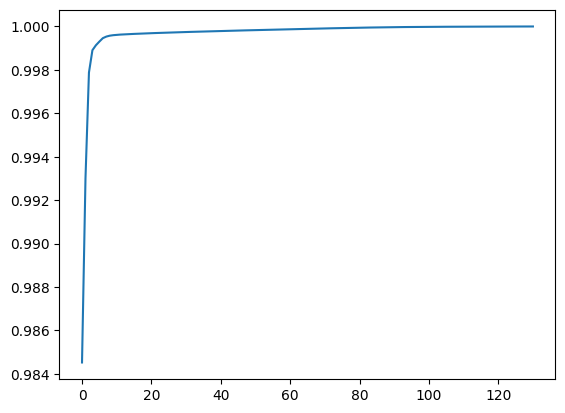

In [10]:
pca = PCA()
pcX = pca.fit_transform(X)
ev = pca.explained_variance_ratio_
cumulativeVar = np.cumsum(ev)
plt.plot(cumulativeVar)

In [11]:
nComp = 5
pca = PCA(n_components=nComp)
pca.fit(X)
pcX = pca.transform(X)

In [12]:
print(pcX.shape)

(449536, 5)


In [43]:
X_train, X_test, y_train, y_test = train_test_split(pcX, y, test_size=0.40, random_state=11, stratify=y)

In [44]:
print(X_train.shape)

(269721, 5)


In [45]:
clf=RandomForestClassifier(n_estimators=100, verbose=2)

In [46]:
clf.fit(X_train,y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.8min finished


RandomForestClassifier(verbose=2)

In [47]:
test_pred=clf.predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.5s finished


In [48]:
train_pred=clf.predict(X_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.7s finished


In [49]:
train_probs = clf.predict_proba(X_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.7s finished


In [50]:
probs = clf.predict_proba(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.6s finished


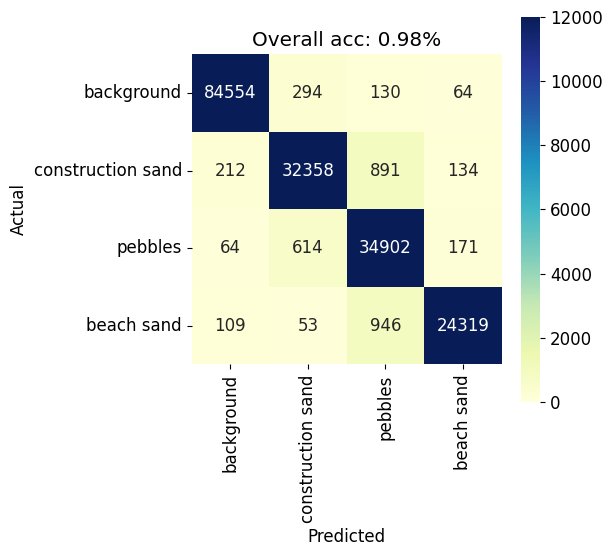

In [51]:
class_labels = ['background', 'construction sand', 'pebbles', 'beach sand']
classes = [1,2,3,4]
 
# multilabel_confusion_matrix(y_true, y_pred, *, sample_weight=None, labels=None, samplewise=False)
cm = confusion_matrix(y_test, test_pred, labels=classes)

df_cm = pd.DataFrame(cm, columns=class_labels, index=class_labels)

fig, ax1 = plt.subplots(1,1, figsize=(5,5))
plt.rcParams['font.size'] = 12

sns.heatmap(df_cm, annot=True, ax=ax1,square=True,  cmap="YlGnBu",vmin=0,vmax=12000,fmt='d')

ax1.set_title('Overall acc: {:.2f}%'.format(accuracy_score(y_test, test_pred)))
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual');

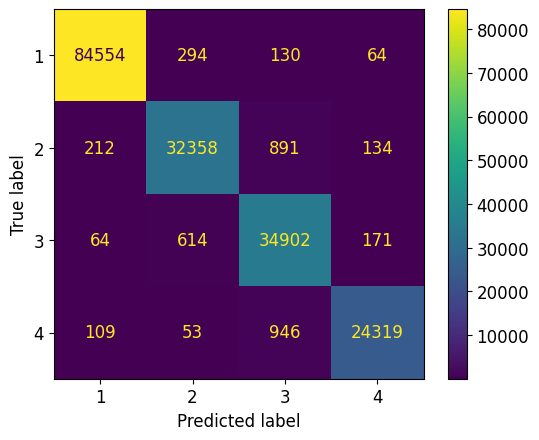

In [52]:
ConfusionMatrixDisplay.from_predictions(y_test, test_pred)

In [53]:
print(classification_report(y_test, test_pred, target_names=class_labels))

                   precision    recall  f1-score   support

       background       1.00      0.99      0.99     85042
construction sand       0.97      0.96      0.97     33595
          pebbles       0.95      0.98      0.96     35751
       beach sand       0.99      0.96      0.97     25427

         accuracy                           0.98    179815
        macro avg       0.97      0.97      0.97    179815
     weighted avg       0.98      0.98      0.98    179815



In [54]:
print(f'Train ROC AUC Score: {roc_auc_score(y_train, train_probs, multi_class="ovr")}')

Train ROC AUC Score: 1.0


In [55]:
print(f'Test ROC AUC  Score: {roc_auc_score(y_test, probs, multi_class="ovr")}')

Test ROC AUC  Score: 0.9983938777163055


In [56]:
def evaluate_model(y_pred, probs, train_predictions, train_probs):    
    baseline = {}    
    baseline['recall']=recall_score(y_test, [1 for _ in range(len(y_test))], average='weighted')    
    baseline['precision'] = precision_score(y_test, [1 for _ in range(len(y_test))], average='weighted')    
    baseline['roc'] = 0.5    
    results = {}    
    results['recall'] = recall_score(y_test, y_pred, average='weighted')    
    results['precision'] = precision_score(y_test, y_pred, average='weighted')    
    results['roc'] = roc_auc_score(y_test, probs, multi_class='ovr')    
    train_results = {}    
    train_results['recall'] = recall_score(y_train, train_predictions, average='weighted')    
    train_results['precision'] = precision_score(y_train, train_predictions, average='weighted')    
    train_results['roc'] = roc_auc_score(y_train, train_probs, multi_class='ovr')
    
    for metric in ['recall', 'precision', 'roc']:            
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}') 
        
    # have to binarise multiclass for roc_curve
    label_binarizer = LabelBinarizer().fit(y_train)
    y_onehot_test = label_binarizer.transform(y_test)
    print(y_onehot_test.shape)  # (n_samples, n_classes)
        
    RocCurveDisplay.from_predictions(
        y_onehot_test.ravel(),
        probs.ravel(),
        name="micro-average OvR",
        color="darkorange",
    )
    plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Micro-averaged One-vs-Rest\nReceiver Operating Characteristic")
    plt.legend()
    plt.show()

/home/solomon/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Recall Baseline: 0.47 Test: 0.98 Train: 1.0
Precision Baseline: 0.22 Test: 0.98 Train: 1.0
Roc Baseline: 0.5 Test: 1.0 Train: 1.0
(179815, 4)


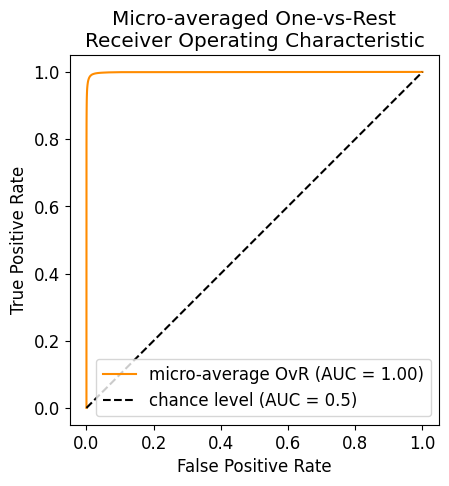

In [57]:
evaluate_model(test_pred,probs,train_pred,train_probs)

## Evaluate on a different image.

In [58]:
test_fn = "processed-data/tertiary-capture/reflectance/2022_11_16/33-2nd/2022_11_16-04_11_30.nc"
test_fn_rad = test_fn.replace('reflectance','radiance')
test_gnd_t_fn = fn.split('.')[0] + ".pkl"

In [59]:
# Load ground truth
with open(test_gnd_t_fn, 'rb') as out_file:
    test_gt = pickle.load(out_file)
    
# Remove erroneous 0 values around edge of image
for i in range(test_gt.shape[0]):
    for j in range(test_gt.shape[1]):
        if test_gt[i,j] == 0:
            test_gt[i,j] = 1
            
test_y = test_gt.copy().reshape(test_gt.shape[0]*test_gt.shape[1]) 

In [60]:
# Load data
test_ds = nc.Dataset(test_fn)
test_ds_rad = nc.Dataset(test_fn_rad)

In [61]:
# extract the datacube from the dataset
test_dc = np.array(test_ds['datacube'])

In [62]:
# Data needs to be x, y, bands instead of bands, x, y.
test_data = test_dc.transpose(1,2,0)

In [63]:
# transform into a line of pixels for PCA
test_X = test_data.copy().reshape(test_data.shape[0]*test_data.shape[1],test_data.shape[2])

## Useful Functions

In [64]:
def process_into_rgb(loc_ds):
    """
    Processes a given dataset into an rgb image for display
    """
    loc_dc = np.array(loc_ds['datacube'])
    loc_binned_wavelengths = np.array(loc_ds['wavelength'])
    loc_image = np.zeros((loc_dc.shape[1],loc_dc.shape[2],3), np.uint8)

    loc_red_wavelength = 620
    loc_green_wavelength = 560
    loc_blue_wavelength = 470

    loc_red_layer = loc_dc[np.argmin(np.abs(loc_binned_wavelengths-loc_red_wavelength)),:,:]  
    loc_green_layer = loc_dc[np.argmin(np.abs(loc_binned_wavelengths-loc_green_wavelength)),:,:] 
    loc_blue_layer = loc_dc[np.argmin(np.abs(loc_binned_wavelengths-loc_blue_wavelength)),:,:] 

    # loc_red_layer = loc_dc[120,:,:]  
    # loc_green_layer = loc_dc[80,:,:] 
    # loc_blue_layer = loc_dc[20,:,:] 

    loc_image[:,:,0] = loc_red_layer
    loc_image[:,:,1] = loc_green_layer
    loc_image[:,:,2] = loc_blue_layer

    # scale the values to within the central 2 to 98 percent values to remove outlier readings
    loc_vmax = np.nanpercentile(loc_image, 98)
    loc_vmin = np.nanpercentile(loc_image, 2)
    loc_image = ((loc_image.astype("f8") - loc_vmin) / (loc_vmax - loc_vmin)).astype("f4")
    loc_image = np.minimum(np.maximum(loc_image, 0), 1)

    loc_image *= 255
    loc_image = loc_image.astype(np.uint8)
    
    return loc_image

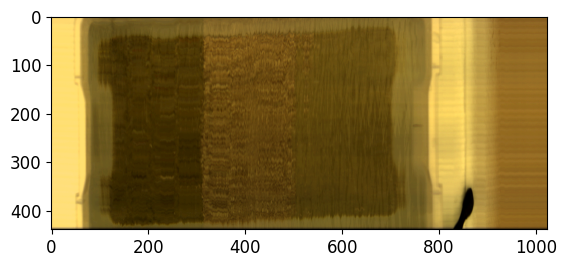

In [65]:
test_img = process_into_rgb(test_ds_rad)
plt.imshow(test_img)

In [66]:
# perform pca on new image
pca.fit(test_X)
test_pcX = pca.transform(test_X)

In [67]:
# make predicitons with classifier
test_test_pred=clf.predict(test_pcX)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    4.8s finished


In [68]:
# transform predictions into image shape
test_x = test_test_pred.reshape(test_img[:, :, 0].shape)

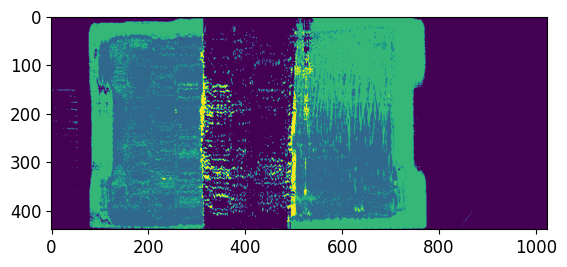

In [69]:
# display image, let plt figure out colours, it will colour each class.
plt.imshow(test_x)

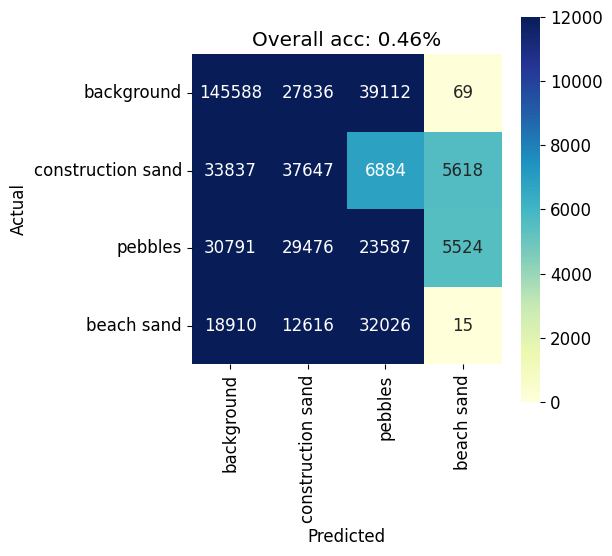

In [70]:
class_labels = ['background', 'construction sand', 'pebbles', 'beach sand']
classes = [1,2,3,4]
 
# multilabel_confusion_matrix(y_true, y_pred, *, sample_weight=None, labels=None, samplewise=False)
cm = confusion_matrix(test_y, test_test_pred, labels=classes)

df_cm = pd.DataFrame(cm, columns=class_labels, index=class_labels)

fig, ax1 = plt.subplots(1,1, figsize=(5,5))
plt.rcParams['font.size'] = 12

sns.heatmap(df_cm, annot=True, ax=ax1,square=True,  cmap="YlGnBu",vmin=0,vmax=12000,fmt='d')

ax1.set_title('Overall acc: {:.2f}%'.format(accuracy_score(test_y, test_test_pred)))
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual');